In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5

import optuna
import warnings
import tensorflow as tf
import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from concurrent.futures import ThreadPoolExecutor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.manifold import TSNE
from sklearn.linear_model import Ridge
from joblib import Parallel, delayed
from sklearn.cluster import DBSCAN
import polars as pl
import polars.selectors as cs

In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [3]:
# Sparse Autoencoder Model
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, sparsity_weight=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_weight = sparsity_weight
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Outputs in the range [0, 1]
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Preparing Data
# Option to use different scalers: MinMaxScaler, StandardScaler, RobustScaler
def prepare_data(data, scaler_type='MinMaxScaler'):
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler()
    
    data_scaled = scaler.fit_transform(data)
    return torch.tensor(data_scaled, dtype=torch.float32), scaler

# Apply PCA for Dimensionality Reduction
# This can help focus the autoencoder on the most relevant features
def apply_pca(data, n_components=0.95):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

# Early Stopping Functionality
def early_stopping(patience):
    class EarlyStopping:
        def __init__(self, patience=patience):
            self.patience = patience
            self.counter = 0
            self.best_loss = float('inf')
            self.early_stop = False
        
        def __call__(self, loss):
            if loss < self.best_loss:
                self.best_loss = loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
    return EarlyStopping()

# Training the Sparse Autoencoder with DataFrame Output
def perform_autoencoder(data, epochs=100, batch_size=32, learning_rate=0.001, patience=10, scaler_type='MinMaxScaler', use_pca=False, sparsity_weight=1e-5):
    # Preprocess Data
    if use_pca:
        data, pca = apply_pca(data)

    data_tensor, scaler = prepare_data(data, scaler_type=scaler_type)
    train_data, val_data = train_test_split(data_tensor, test_size=0.2, random_state=42)

    train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data), batch_size=batch_size, shuffle=False)

    model = SparseAutoencoder(input_dim=data.shape[1], sparsity_weight=sparsity_weight)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.SmoothL1Loss()  # Changed to Smooth L1 Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    stopper = early_stopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            encoded, outputs = model(batch)
            
            # Reconstruction loss
            loss = criterion(outputs, batch)
            
            # Sparsity penalty (L1 regularization on encoded activations)
            l1_penalty = torch.mean(torch.abs(encoded))
            loss += sparsity_weight * l1_penalty
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch[0].to(device)
                _, outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item() * batch.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        stopper(val_loss)
        if stopper.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Convert tensor back to DataFrame for consistency
    _, data_decoded = model(data_tensor.to(device))
    data_decoded = data_decoded.cpu().detach().numpy()
    df_encoded = pd.DataFrame(data_decoded, columns=[f'feature_{i}' for i in range(data_decoded.shape[1])])
    return df_encoded

In [4]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['hoursday_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] / df['BMI_Age']

    df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    df['Sex_BMI'] = df['Basic_Demos-Sex'] * df['Physical-BMI']
    df['Sex_HeartRate'] = df['Basic_Demos-Sex'] * df['Physical-HeartRate']
    df['Age_WaistCirc'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
    df['BMI_FitnessMaxStage'] = df['Physical-BMI'] * df['Fitness_Endurance-Max_Stage']
    df['Weight_GripStrengthDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSD']
    df['Weight_GripStrengthNonDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    df['HeartRate_FitnessTime'] = df['Physical-HeartRate'] * (df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'])
    df['Age_PushUp'] = df['Basic_Demos-Age'] * df['FGC-FGC_PU']
    df['FFMI_Age'] = df['BIA-BIA_FFMI'] * df['Basic_Demos-Age']
    df['InternetUse_SleepDisturbance'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['SDS-SDS_Total_Raw']
    df['CGAS_BMI'] = df['CGAS-CGAS_Score'] * df['Physical-BMI']
    df['CGAS_FitnessMaxStage'] = df['CGAS-CGAS_Score'] * df['Fitness_Endurance-Max_Stage']
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, epochs=100, batch_size=32, learning_rate=0.001, patience=10, use_pca=False, scaler_type='MinMaxScaler', sparsity_weight=1e-5)
test_ts_encoded = perform_autoencoder(df_test, epochs=100, batch_size=32, learning_rate=0.001, patience=10, use_pca=False, scaler_type='MinMaxScaler', sparsity_weight=1e-5)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

100%|██████████| 2/2 [00:00<00:00, 10.99it/s]


Epoch 1, Train Loss: 0.0482, Validation Loss: 0.0418
Epoch 2, Train Loss: 0.0283, Validation Loss: 0.0200
Epoch 3, Train Loss: 0.0188, Validation Loss: 0.0184
Epoch 4, Train Loss: 0.0181, Validation Loss: 0.0181
Epoch 5, Train Loss: 0.0180, Validation Loss: 0.0180
Epoch 6, Train Loss: 0.0179, Validation Loss: 0.0179
Epoch 7, Train Loss: 0.0176, Validation Loss: 0.0172
Epoch 8, Train Loss: 0.0163, Validation Loss: 0.0146
Epoch 9, Train Loss: 0.0137, Validation Loss: 0.0121
Epoch 10, Train Loss: 0.0121, Validation Loss: 0.0110
Epoch 11, Train Loss: 0.0111, Validation Loss: 0.0102
Epoch 12, Train Loss: 0.0105, Validation Loss: 0.0098
Epoch 13, Train Loss: 0.0100, Validation Loss: 0.0090
Epoch 14, Train Loss: 0.0085, Validation Loss: 0.0070
Epoch 15, Train Loss: 0.0068, Validation Loss: 0.0059
Epoch 16, Train Loss: 0.0063, Validation Loss: 0.0058
Epoch 17, Train Loss: 0.0062, Validation Loss: 0.0058
Epoch 18, Train Loss: 0.0061, Validation Loss: 0.0056
Epoch 19, Train Loss: 0.0060, Validat

In [5]:
train = train.drop('id', axis=1)
test_id = test["id"]  # for submit
test = test.drop('id', axis=1)

In [6]:
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [7]:
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','Age_Weight','Sex_BMI','Sex_HeartRate','Age_WaistCirc','BMI_FitnessMaxStage','Weight_GripStrengthDominant','Weight_GripStrengthNonDominant','HeartRate_FitnessTime',
'Age_PushUp','FFMI_Age','InternetUse_SleepDisturbance','CGAS_BMI','CGAS_FitnessMaxStage']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','Age_Weight','Sex_BMI','Sex_HeartRate','Age_WaistCirc','BMI_FitnessMaxStage','Weight_GripStrengthDominant','Weight_GripStrengthNonDominant','HeartRate_FitnessTime',
'Age_PushUp','FFMI_Age','InternetUse_SleepDisturbance','CGAS_BMI','CGAS_FitnessMaxStage']

featuresCols += time_series_cols
test = test[featuresCols]

Unique clusters: 29
Noise points: 3582
Cluster 'sii' modes:
-1     0.0
 0     1.0
 1     0.0
 2     1.0
 3     1.0
 4     0.0
 5     0.0
 6     0.0
 7     1.0
 8     0.0
 9     0.0
 10    0.0
 11    0.0
 12    0.0
 13    1.0
 14    2.0
 15    0.0
 16    0.0
 17    0.0
 18    1.0
 19    0.0
 20    0.0
 21    1.0
 22    0.0
 23    0.0
 24    2.0
 25    1.0
 26    1.0
 27    1.0
 28    1.0
dtype: float64


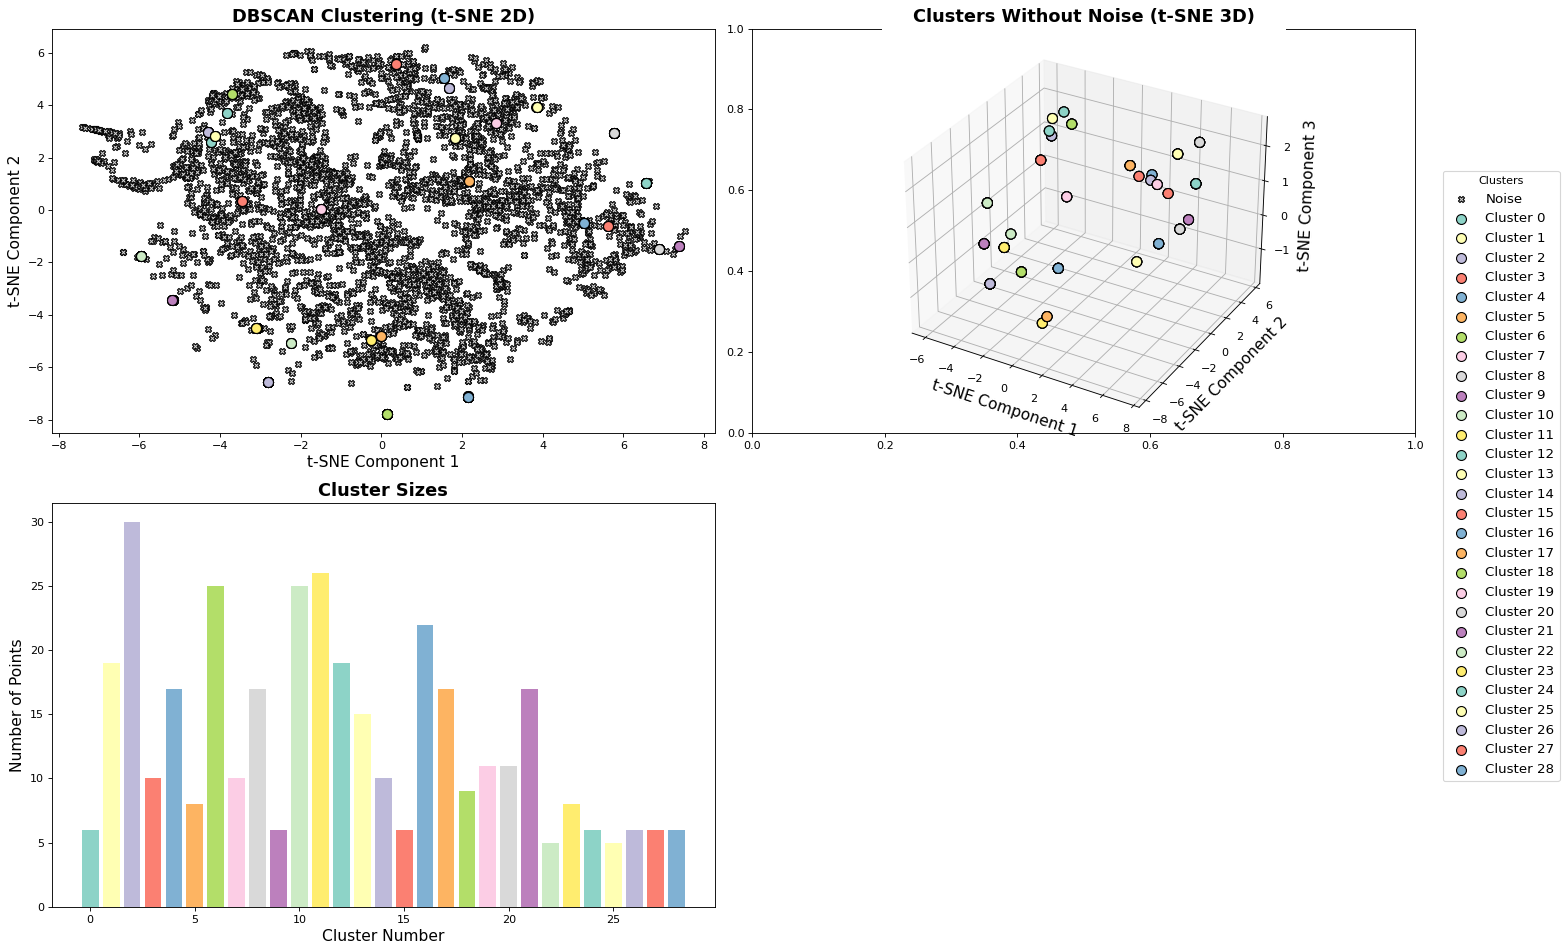

In [8]:
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)
    
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

train_df_le = train
test_df_le = test

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# DBSCAN clustering

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Save the 'sii' column
train_sii = train_df_le['sii'].copy()

# Find common columns between train and test data
common_columns = train_df_le.columns.intersection(test_df_le.columns)
train_df_le = train_df_le[common_columns]
test_df_le = test_df_le[common_columns]
train_df_le['sii'] = train_sii

# Pipeline: Fill missing values with the mean
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
])

y = train_df_le['sii']
train_df_le = train_df_le.drop(columns=['sii'])
train_df_le = preprocessor.fit_transform(train_df_le)
train_df_le = pd.DataFrame(train_df_le, columns=common_columns)
train_df_le['sii'] = y

# Standardize numerical columns
numeric_cols = train_df_le.select_dtypes(include=[np.number]).columns  
numeric_cols = numeric_cols.drop('sii')  # Exclude 'sii'
scaler = StandardScaler()
train_df_le[numeric_cols] = scaler.fit_transform(train_df_le[numeric_cols])

# Preprocess the test data
test_df_le = preprocessor.transform(test_df_le)
test_df_le = pd.DataFrame(test_df_le, columns=common_columns)
test_df_le[numeric_cols] = scaler.transform(test_df_le[numeric_cols])

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  
train_clusters = dbscan.fit_predict(train_df_le)

print(f"Unique clusters: {len(np.unique(train_clusters[train_clusters != -1]))}")
print(f"Noise points: {np.sum(train_clusters == -1)}")

# Find the mode of 'sii' for each cluster
cluster_modes = pd.Series(index=np.unique(train_clusters), dtype=float)

for cluster_num in np.unique(train_clusters):  
    cluster_rows = train_df_le[train_clusters == cluster_num]
    cluster_sii = y[train_clusters == cluster_num]  # 'sii'
    cluster_modes[cluster_num] = cluster_sii.mode()[0] 

print("Cluster 'sii' modes:")
print(cluster_modes)

# Fill missing 'sii' values based on the cluster modes
train_df_le.loc[train_df_le['sii'].isnull(), 'sii'] = [
    cluster_modes[train_clusters[i]] for i in range(len(train_clusters))
]
X = train_df_le

# Perform t-SNE to reduce dimensions to 3D for visualization
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
train_df_le_tsne = tsne.fit_transform(train_df_le)

# DBSCAN clustering results (-1 indicates noise)
train_clusters = dbscan.labels_

# Set up the plot size and layout (4 subplots: 3D, 2D, Bar Chart)
fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=80, subplot_kw={'projection': None})

# Define custom color palette for clusters
num_clusters = len(np.unique(train_clusters)) - 1  # Exclude noise (-1)
palette = sns.color_palette("Set3", n_colors=num_clusters)

# Plot 1: Clusters (2D scatter using t-SNE components 1 & 2)
ax1 = axes[0, 0]
for cluster_num in np.unique(train_clusters):
    if cluster_num == -1:  # Noise points
        ax1.scatter(train_df_le_tsne[train_clusters == cluster_num, 0], 
                    train_df_le_tsne[train_clusters == cluster_num, 1], 
                    color='lightgray', label='Noise', s=30, edgecolor='k', marker='X')
    else:
        ax1.scatter(train_df_le_tsne[train_clusters == cluster_num, 0], 
                    train_df_le_tsne[train_clusters == cluster_num, 1], 
                    color=palette[cluster_num % len(palette)], 
                    label=f'Cluster {cluster_num}', s=80, edgecolor='k')

ax1.set_title('DBSCAN Clustering (t-SNE 2D)', fontsize=16, weight='bold')
ax1.set_xlabel('t-SNE Component 1', fontsize=14)
ax1.set_ylabel('t-SNE Component 2', fontsize=14)

# Plot 2: Clusters Only (3D scatter)
ax2 = fig.add_subplot(222, projection='3d')
for cluster_num in np.unique(train_clusters):
    if cluster_num != -1:  # Exclude Noise points
        ax2.scatter(train_df_le_tsne[train_clusters == cluster_num, 0], 
                    train_df_le_tsne[train_clusters == cluster_num, 1], 
                    train_df_le_tsne[train_clusters == cluster_num, 2], 
                    color=palette[cluster_num % len(palette)], 
                    label=f'Cluster {cluster_num}', s=80, edgecolor='k')

ax2.set_title('Clusters Without Noise (t-SNE 3D)', fontsize=16, weight='bold')
ax2.set_xlabel('t-SNE Component 1', fontsize=14)
ax2.set_ylabel('t-SNE Component 2', fontsize=14)
ax2.set_zlabel('t-SNE Component 3', fontsize=14)

# Bar chart: Cluster Sizes
ax3 = axes[1, 0]
cluster_sizes = pd.Series(train_clusters).value_counts().sort_index()
cluster_sizes = cluster_sizes[cluster_sizes.index != -1]  # Exclude Noise

ax3.bar(cluster_sizes.index, cluster_sizes.values, color=palette[:len(cluster_sizes)])
ax3.set_title('Cluster Sizes', fontsize=16, weight='bold')
ax3.set_xlabel('Cluster Number', fontsize=14)
ax3.set_ylabel('Number of Points', fontsize=14)

# Remove the unnecessary fourth plot (bottom-right)
fig.delaxes(axes[1, 1])

# Add legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Clusters")

plt.tight_layout()
plt.show()

In [9]:
# 'sii' 
y = X['sii']
X = X.drop(columns=['sii'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Columns: 172 entries, Basic_Demos-Age to feature_95
dtypes: float64(172)
memory usage: 5.2 MB


In [10]:
# Convert numpy.ndarray to pandas DataFrame
test_df_le = pd.DataFrame(test_df_le)

# Now you can use .info() to inspect the DataFrame
test_df_le.info()
# test_df_le.columns = X.columns
X_test = test_df_le

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 172 entries, Basic_Demos-Age to feature_95
dtypes: float64(172)
memory usage: 27.0 KB


In [11]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

In [12]:
# Model parameters for LightGBM
LGBM_Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    # 'cat_features': cat_c,

}

In [13]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [14]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [15]:
# Pytorch_TabNet

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Create internal validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=500,
            patience=50,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model

In [16]:
# Create model instances
Light = LGBMRegressor(**LGBM_Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
TabNet_Model = TabNetWrapper(**TabNet_Params) 

In [17]:
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
    ('tabnet', TabNet_Model)
],weights=[4.0,4.0,5.0,4.0])

Submission1 = TrainML(voting_model, test)

Submission1

Training Folds: 100%|██████████| 5/5 [02:58<00:00, 35.71s/it]

Mean Train QWK --> 0.7433
Mean Validation QWK ---> 0.4791
----> || Optimized QWK SCORE ::  0.533


,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,0
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


In [18]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission2 = TrainML(voting_model, test)

# Save submission
#Submission2.to_csv('submission.csv', index=False)
Submission2

Training Folds: 100%|██████████| 5/5 [00:48<00:00,  9.71s/it]

Mean Train QWK --> 0.7595
Mean Validation QWK ---> 0.3926


----> || Optimized QWK SCORE ::  0.457


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0


In [19]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tp_rounded

imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

Submission3 = TrainML(ensemble, test)
Submission3 = pd.DataFrame({
    'id': sample['id'],
    'sii': Submission3
})

Submission3

Training Folds: 100%|██████████| 5/5 [01:57<00:00, 23.50s/it]

Mean Train QWK --> 0.9175
Mean Validation QWK ---> 0.3803


----> || Optimized QWK SCORE ::  0.450


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


In [20]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii'],
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [21]:
final_submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0
